In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.patches import Polygon
import numpy as np
import glob
import ntpath
import os
%matplotlib inline

In [2]:
def imshow_compare2(img1, img2, title1, title2, cmap = 'gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2, cmap=cmap)
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('output_images/'+ title2 + '.jpg')

    
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

### Step 1: Camera calibration
In this step, I calculate camera calibration matrix using chessboard images

In [3]:
def camera_calib(images, nx = 9, ny = 6):
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    
    # use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calib(images)

### Step 2: Distortion correction 
Simply apply distortion correction using  __[cv2.undistort()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html)__ function

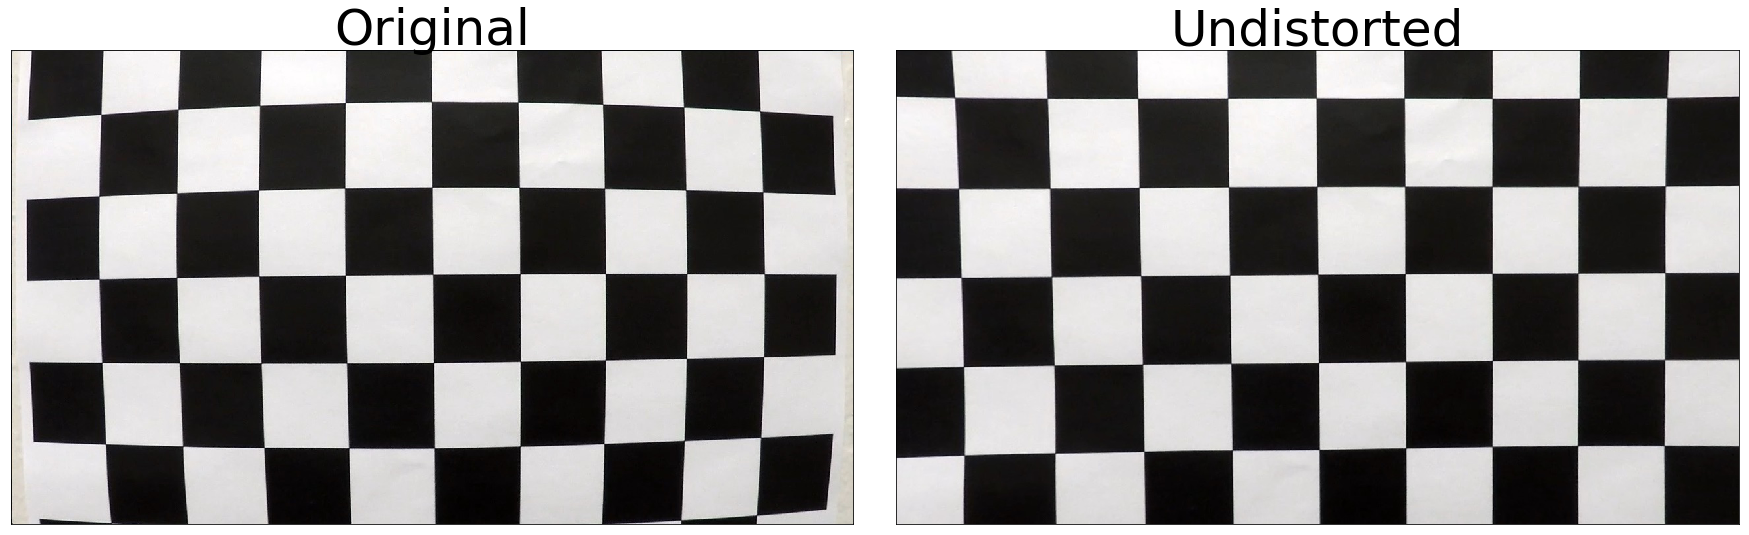

In [4]:
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
imshow_compare2(img, undistorted, 'Original', 'Undistorted')

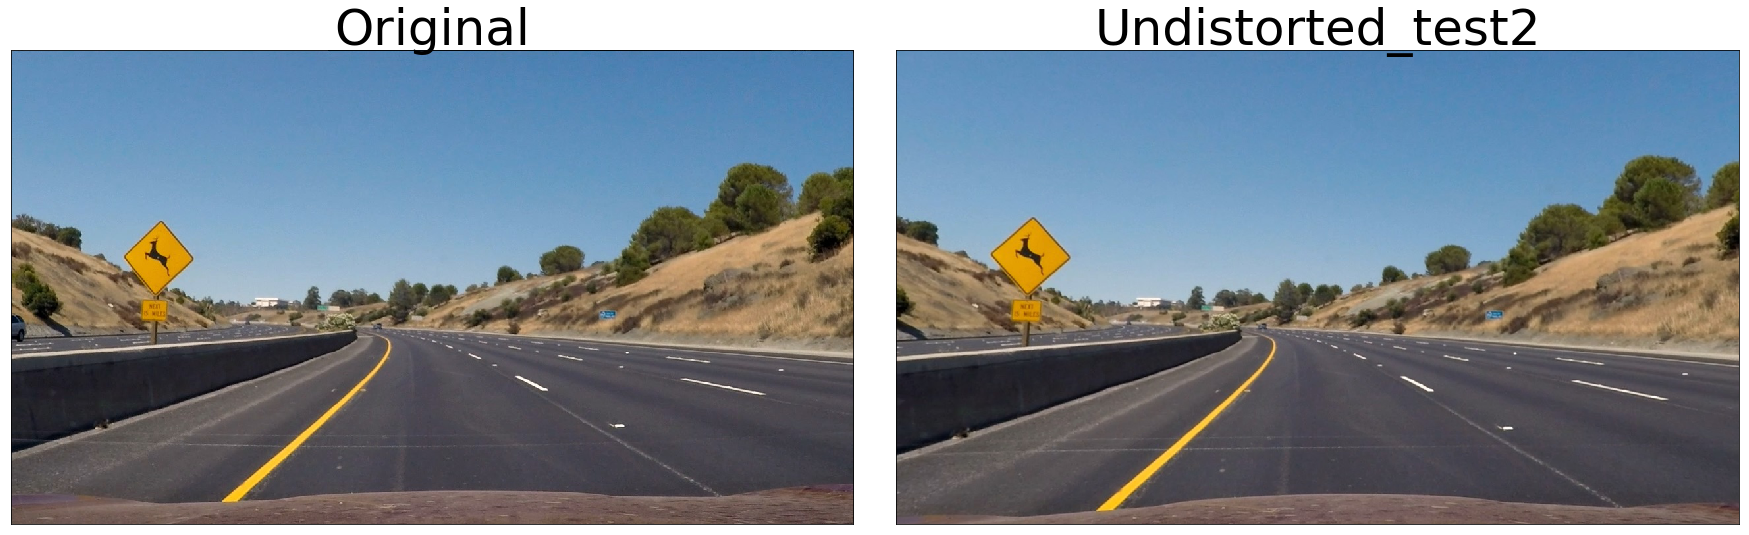

In [5]:
img = mpimg.imread('test_images/test2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
imshow_compare2(img, undistorted, 'Original', 'Undistorted_test2')

### Step 3: Create threshholded binary image


In [6]:
def get_thresholded_image(img, k_size = 3, s_thresh = (100, 255), sx_thresh = [10, 200], l_thresh = [120, 255], color_threshold = 150):
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', k_size, sx_thresh[0], sx_thresh[1])
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray,sobel_kernel=k_size, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3,  thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

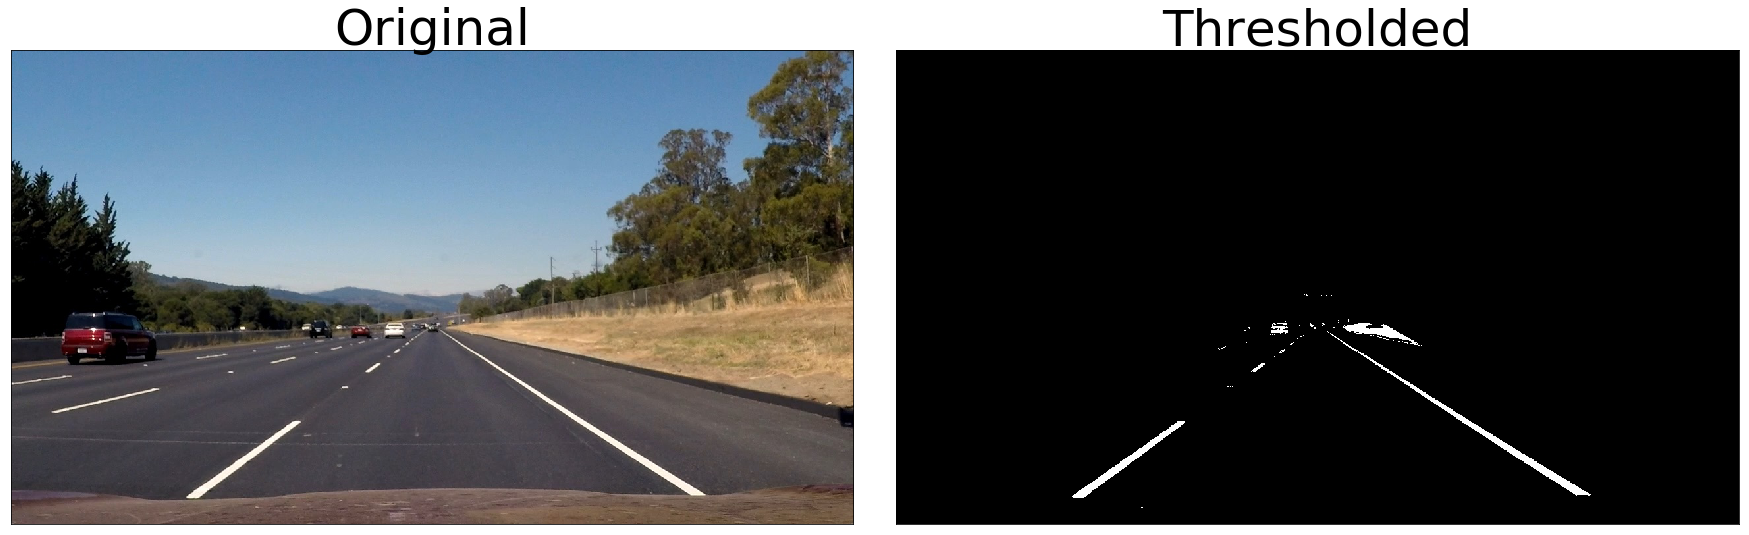

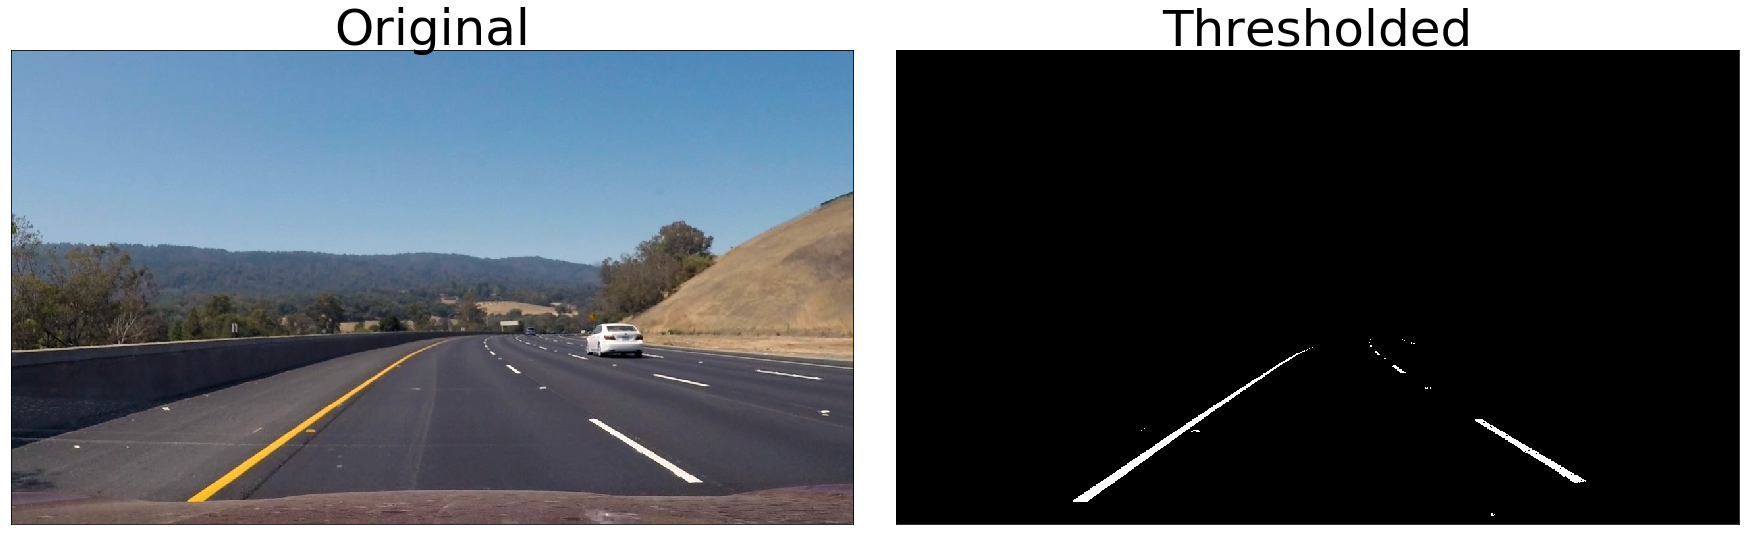

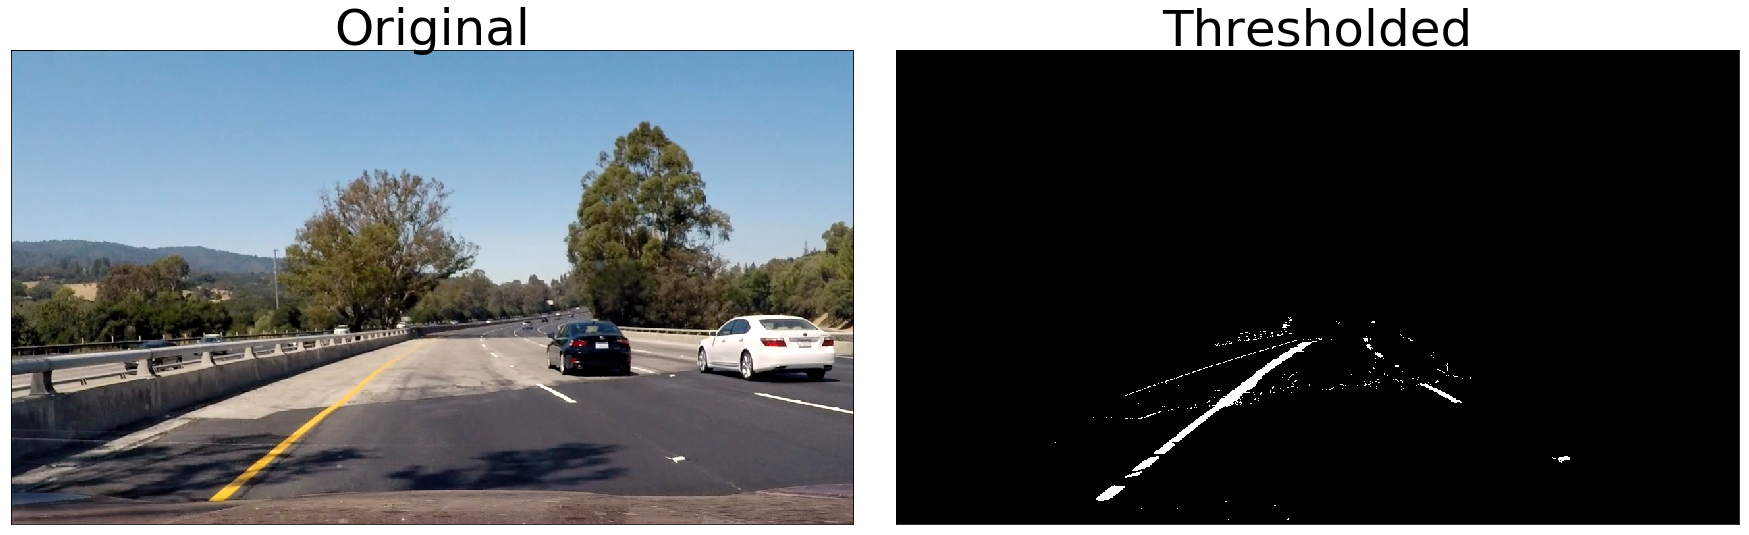

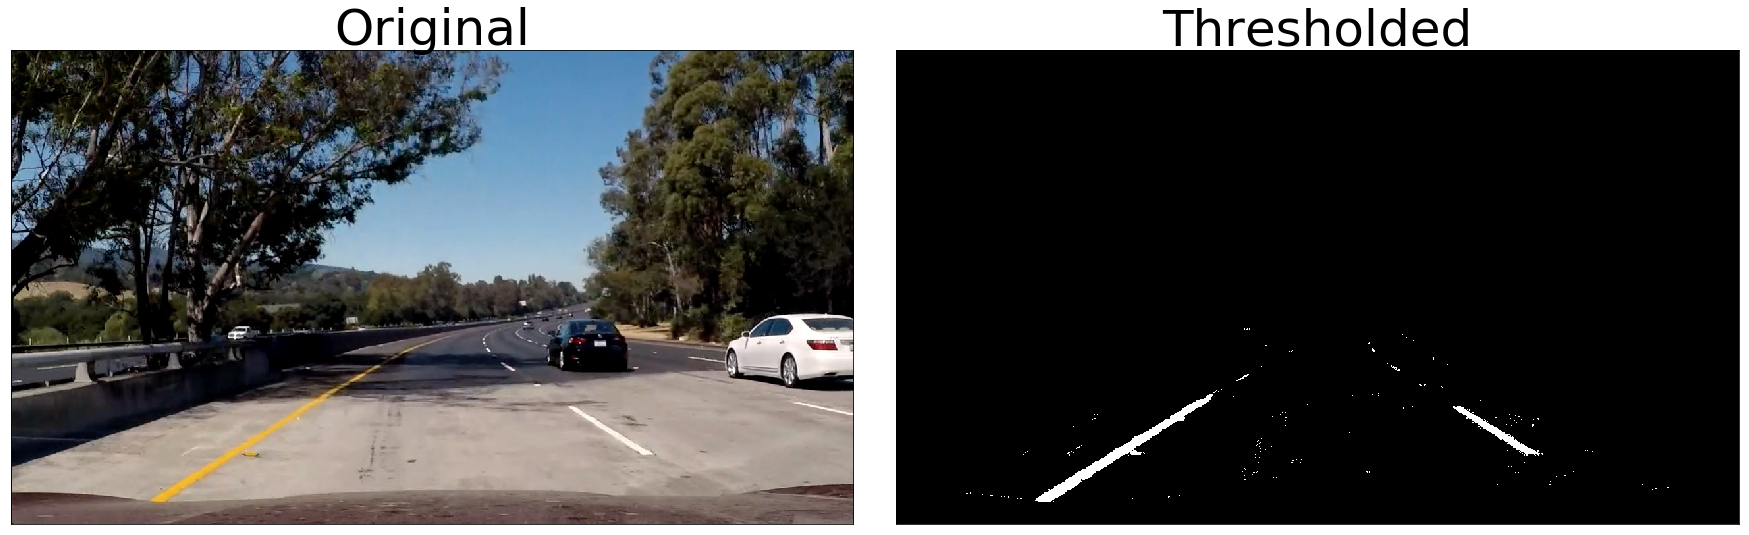

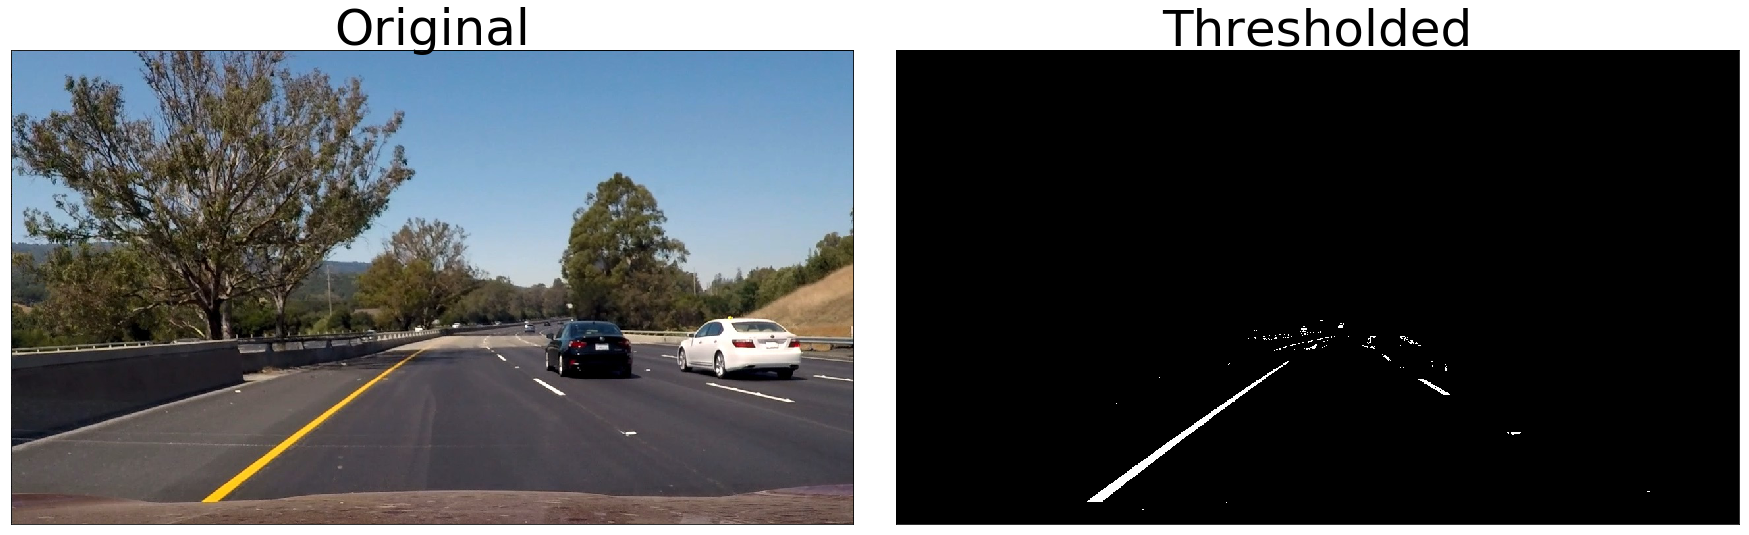

In [7]:
images = glob.glob("test_images/*.jpg")
for fname in images:
        img = mpimg.imread(fname)
        thresholded = get_thresholded_image(img)
        file_name = path_leaf(fname)
        output_name = os.path.join("output_images", 'thresholded_'+ file_name)
        thresholded = cv2.cvtColor(thresholded*255, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(output_name, thresholded)
        imshow_compare2(img, thresholded, 'Original', 'Thresholded')

### Step 4: perspective transform

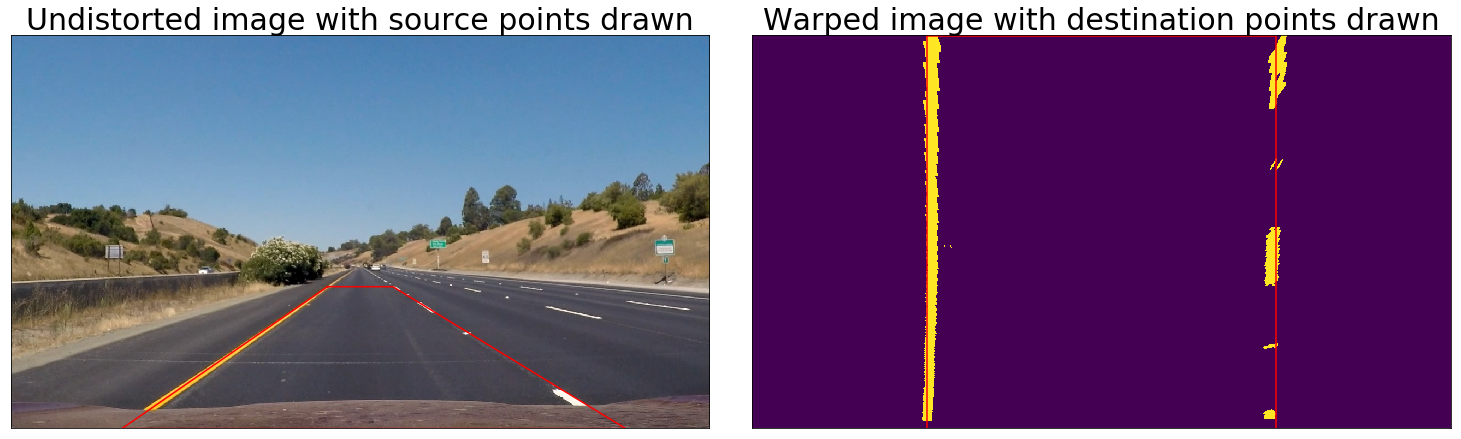

In [8]:
# Define perspective transform function
def warp(src_coordinates=None, dst_coordinates=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    return M, Minv

img = mpimg.imread(images[0])
img_size = (img.shape[1], img.shape[0])


src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


M, Minv = warp(src, dst)

#for fname in images:
#thresholded = color_grid_thresh(img)
thresholded = get_thresholded_image(img)
warped = cv2.warpPerspective(thresholded, M, img_size, flags=cv2.INTER_LINEAR)
file_name = path_leaf(fname)
output_name = os.path.join("output_images", 'Wraped_'+ file_name)

cv2.imwrite(output_name, warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Undistorted image with source points drawn', fontsize=30)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.imshow(img)

ax2.set_title('Warped image with destination points drawn', fontsize=30)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.imshow(warped)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warped.jpg')

In [9]:
def line_pred(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def lane_search(warped, nwindows = 10, margin = 50, min_pix = 50, demo = False):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    out_img = np.dstack((warped, warped, warped))*255
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width


    window_height = np.int(num_rows//nwindows)
   
    left_coordinates = []
    right_coordinates = []

    for window in range(nwindows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - margin
        left_x_max = leftx_base + margin
        
        

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pix:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - margin
        right_x_max = rightx_base + margin
        
       
        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pix:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
        if demo:
            cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
            cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
            

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    if demo:
        out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
        out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]
    
    left_x_predictions, right_x_predictions = line_pred(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions, out_img

In [ ]:
leftx_pred, rightx_pred, out_img = lane_search(warped, demo=True)
num_rows = warped.shape[0]
y_points = np.linspace(0, num_rows-1, num_rows)
plt.imshow(out_img)
plt.plot(leftx_pred, y_points, color='yellow')
plt.plot(rightx_pred, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)
plt.savefig('output_images/color_fit_lines.jpg')

In [11]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def ave_curv(left_x, right_x):
    left_curve_rad = measure_radius_of_curvature(left_x)
    right_curve_rad = measure_radius_of_curvature(right_x)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    return average_curve_rad

average_curve_rad = ave_curv(leftx_pred, rightx_pred)
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)


def comp_offset(left_x, right_x):
    lane_center = (right_x[num_rows-1] + left_x[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    return center_offset_mtrs


center_offset_mtrs = comp_offset(leftx_pred, rightx_pred)
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 3679.23 m
Center offset: 0.03 m


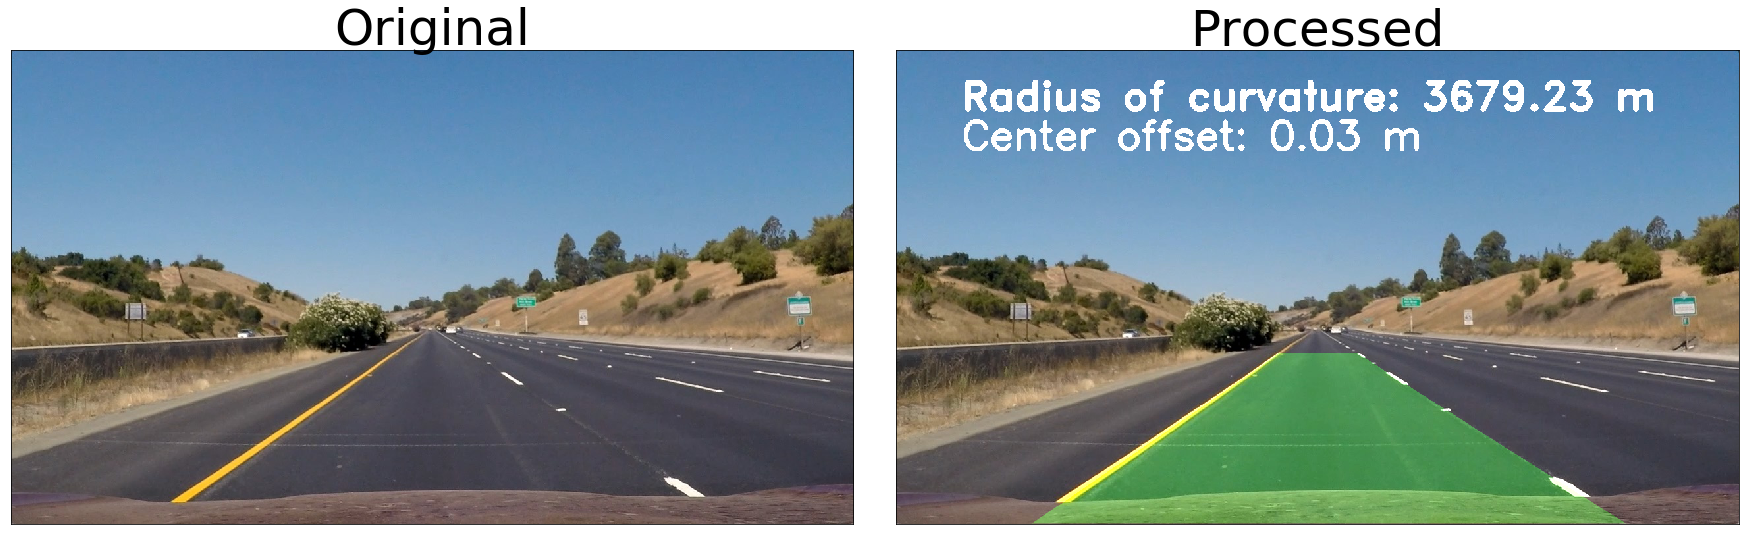

In [12]:
def draw_lane(img, warped, left_x, right_x, y):
    out_img = np.dstack((warped, warped, warped))*255

    y_points = np.linspace(0, num_rows-1, num_rows)

    left_line_window = np.array(np.transpose(np.vstack([left_x, y])))

    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x, y]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    average_curve_rad = ave_curv(left_x, right_x)
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    center_offset_mtrs = comp_offset(left_x, right_x)
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255), thickness=5)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=5)
    
    return result
result = draw_lane(img,warped, leftx_pred, rightx_pred, y_points)
imshow_compare2(img, result, 'Original', 'Processed')

In [13]:
def ave_line(previous_lines, new_line, num_frames = 12):
    """
        This function computes an averaged lane line by averaging over previous good frames.
        Input:
        num_frames : Number of frames to average over
        
    """
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_dist(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average


In [14]:
class Pipeline():
    '''
    pipeline class with has left/right line class to hold the related information
    '''
    # Get cal and tranform parameter, set as class variable
    print("Import the camera calbration parameter & view_perspective tranform parameter...")
    images = glob.glob('./camera_cal/calibration*.jpg')
    mtx, dist = camera_calib(images)
    img = mpimg.imread(images[0])
    img_size = (img.shape[1], img.shape[0])

    M, Minv = warp(src, dst)

    def __init__(self):
        self.image_counter = 0 		# the image counter
        self.fit_fail_counter = 0	# this is used record the fit lane not meet the requirement
        self.fit_ok = False		# flag use to record fit lane is ok or not
        self.search_fail_counter = 0 # this is used to record lane pixel search failure.
        self.radius = [] # store the radius data, arverage of left/right lane cur
        self.offset = [] # store the car center offset from lane center
        self.brute = False # not implement, use last time fit line to quick search the lane points
        self.nWindows = 9   # The number of sliding windows
        self.margin = 50  # Set the width of the windows +/- margin
        self.min_pix = 50  # Set minimum number of pixels found to recenter window
        self.k_size = 3    # sobel kernel size
        self.s_thresh=(100, 255)
        self.sx_thresh= [10, 200]
        self.l_thresh = [120, 255]
        self.color_thresh = 150
        self.bad_lines = False # flag use to record lane search is ok or not
        self.running_diff = 0
        self.left_lines = []
        self.right_lines = []
        self.fit_left =  None
        self.fit_right = None
        self.num_frames = 12
        
    def pipeline(self, image):
        # counter the image
        self.image_counter += 1

        img_size = (image.shape[1], image.shape[0])

        # distort the image
        image_undist = cv2.undistort(image, Pipeline.mtx, Pipeline.dist, None, Pipeline.mtx)

        # apply thresholding
        image_threshed = get_thresholded_image(image_undist, k_size = self.k_size,
                                               s_thresh = self.s_thresh,
                                               sx_thresh = self.sx_thresh,
                                               l_thresh = self.l_thresh,
                                               color_threshold = self.color_thresh)
    
        # apply the view_perspective tranform
        warped = cv2.warpPerspective(image_threshed, M, img_size , flags=cv2.INTER_LINEAR)
    
        out_img = np.dstack((warped, warped, warped))*255

        non_zeros = warped.nonzero()
        non_zeros_y = non_zeros[0]
        non_zeros_x = non_zeros[1]

        num_rows = warped.shape[0]
        y_points = np.linspace(0, num_rows-1, num_rows)

        if (self.fit_left is None) or (self.fit_right is None):
            # If the polynomial coefficients of the previous frames are None then perform a brute force search
            self.brute = True
            leftx_pred, rightx_pred, output_img= lane_search(warped,
                                                             nwindows = self.nWindows,
                                                             margin = self.margin,
                                                             min_pix = self.min_pix)
        else:
            # Else search in a margin of x pixels on each side of the pervious polynomial fit
            self.brute = False
            leftx_pred = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
            left_coord = ((non_zeros_x >= leftx_pred - self.margin) & (non_zeros_x <= leftx_pred + self.margin)).nonzero()[0]

            rightx_pred = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
            right_coord = ((non_zeros_x >= rightx_pred - self.margin) & (non_zeros_x <= rightx_pred + self.margin)).nonzero()[0]

            leftx_pred, rightx_pred = line_pred(non_zeros_x, non_zeros_y, left_coord, right_coord, num_rows)

        if (leftx_pred is None or rightx_pred is None):
            if not self.brute:
                leftx_pred, rightx_pred, output_img= lane_search(warped,
                                                                 nwindows = self.nWindows, 
                                                                 margin = self.margin, 
                                                                 min_pix = self.min_pix)

        if (leftx_pred is None or rightx_pred is None):
            bad_lines = True
        else:
            mean_diff = np.mean(rightx_pred - leftx_pred)

            if self.running_diff == 0:
                self.running_diff = mean_diff

            if (mean_diff < 0.7*self.running_diff or mean_diff > 1.3*self.running_diff):
                self.bad_lines = True
                if not self.brute:
                    leftx_pred, rightx_pred, output_img= lane_search(warped,
                                                                     nwindows = self.nWindows, 
                                                                     margin = self.margin, 
                                                                     min_pix = self.min_pix)
                    if (leftx_pred is None or rightx_pred is None):
                        self.bad_lines = True
                    else:
                        mean_diff = np.mean(rightx_pred - leftx_pred)
                        if (mean_difference < 0.7*self.running_diff or mean_diff > 1.3*self.running_diff):
                            self.bad_lines = True
                        else:
                            self.bad_lines = False
            else:
                self.bad_lines = False

        if self.bad_lines:
            if len(self.left_lines) == 0 and len(self.right_lines) == 0:
                return img
            else:
                leftx_pred = self.left_lines[-1]
                rightx_pred = self.right_lines[-1]
        else:
            self.left_lines, leftx_pred = ave_line(self.left_lines, leftx_pred, self.num_frames)
            self.right_lines, rightx_pred = ave_line(self.right_lines, rightx_pred, self.num_frames)
            mean_diff = np.mean(rightx_pred - leftx_pred)
            self.running_diff = 0.9*self.running_diff + 0.1*mean_diff

        # compute the radius of curvature
        result = draw_lane(image,warped, leftx_pred, rightx_pred, y_points)
        return result

Import the camera calbration parameter & view_perspective tranform parameter...


In [15]:
input_video = './project_video.mp4'
output_video = 'output_images/project_video_output.mp4'

clip = VideoFileClip(input_video)
pipeline = Pipeline()
white_clip = clip.fl_image(pipeline.pipeline)

%time white_clip.write_videofile(output_video, audio=False)
clip.reader.close()

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:24<00:00,  3.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 3min 25s


In [16]:
sub_clip = white_clip.subclip((0,30),(0,35)).resize(0.3)
sub_clip.write_gif("output_images/project_vieo_subclip.gif")
HTML('''<div style="display: flex; justify-content: row;"> 
    <img src="output_images/project_vieo_subclip.gif"> </div>''')


[MoviePy] Building file output_images/project_vieo_subclip.gif with imageio


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:35<00:00,  4.48it/s]


In [17]:
input_video = './challenge_video.mp4'
output_video = 'output_images/challenge_video_output.mp4'

clip2 = VideoFileClip(input_video)

pipeline = Pipeline()
white_clip2 = clip2.fl_image(pipeline.pipeline)

%time white_clip2.write_videofile(output_video, audio=False)
clip2.reader.close()

[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:25<00:00,  5.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video_output.mp4 

Wall time: 1min 26s


In [18]:
sub_clip2 = white_clip2.subclip((0,5),(0,20)).resize(0.3)
sub_clip2.write_gif("output_images/challenge_vieo_subclip.gif")
HTML('''<div style="display: flex; justify-content: row;"> 
    <img src="output_images/challenge_vieo_subclip.gif"> </div>''')


[MoviePy] Building file output_images/challenge_vieo_subclip.gif with imageio


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [01:44<00:00,  4.48it/s]


In [19]:
output = 'output_images/harder_challenge_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
pipeline = Pipeline()
pipeline.nWindows = 18
pipeline.num_frames = 5
white_clip3 = clip3.fl_image(pipeline.pipeline)
%time white_clip3.write_videofile(output, audio=False)
clip3.reader.close()

[MoviePy] >>>> Building video output_images/harder_challenge_output.mp4
[MoviePy] Writing video output_images/harder_challenge_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:51<00:00,  5.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_output.mp4 

Wall time: 3min 52s


In [20]:
sub_clip = white_clip3.subclip((0,30),(0,35)).resize(0.3)
sub_clip.write_gif('output_images/harder_challenge_subclip.gif')
HTML('''<div style="display: flex; justify-content: row;"> 
    <img src="output_images/harder_challenge_subclip.gif"> </div>''')


[MoviePy] Building file output_images/harder_challenge_subclip.gif with imageio


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:44<00:00,  2.71it/s]
